# 1. Information about the submission

## 1.1 Name and number of the assignment 

**Word Sense Induction**. Assignment 1

## 1.2 Student name

 **Nikolay Kalmykov**

## 1.3 Codalab user ID

**Niсk**

# 2. Technical Report

## 2.1 Methodology 

I used `RuBert-based model of DeepPavlov` (12-layer, 768-hidden, 12-heads, 180M parameters), that was trained on the Russian part of Wikipedia and news data.

The main advantage of BERT over models like Word2Vec is the producing of word representations that are dynamically informed by the words around them.

1) Use the column `positions` and find the indexes of tokens that correspond to `target words` from column `word`.

2) Convert tokens to PyTorch tensors, run the data through BERT model and collect all of the hidden states.

3) Find the sum of the vectors from the `last of 4 layers`.

4) Calculate the final context embedding (`sum of weighted token embeddings`).

5) Select the number of clusters with `silhouette` analysis.

6) Use `KMeans` for clustering.

## 2.2 Discussion of results

The BERT model with weighted sum works quite well for `wiki-wiki` and `bts-rnc` dataset.

Method | ARI of wiki-wiki | ARI of bts-rnc | ARI of active-dict
--- | --- | --- | --- |
Baseline | 0.5275 | 0.2133 | 0.1181
BERT | 0.9428 | 0.2949 | 0.1538

But, the ARI score for `active-dict` is slightly below Baseline. This dataset is a bit weird, because in some contexts the `target word` began to disappear, contexts from one word began to appear, and so on. It doesn't quite fit the task. However, in order to improve the speed on the `active-dict` dataset, you can try to take other models like ELMO, etc (which will be under this domain of phrases, words, etc.).

# 3. Code

## 3.1 Requirements

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pymystem3==0.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-11-30 20:46:11--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.242, 5.45.205.243, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-11-30 20:46:11--  http://cachev2-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm902.cdn.yandex.net (cachev2-mskm902.cdn.yandex.net)... 5.45.220.91, 2a02:6b8:0:2002::991
Connecting to cachev2-mskm902.cdn.yandex.net (cachev2-mskm902.cdn.yandex.net)|5.45.220.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linux3.

In [4]:
from transformers import BertTokenizer, BertModel
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics

from typing import Tuple
from pymystem3 import Mystem
mystem = Mystem() 
import re

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 3.2 Download the data

### wiki-wiki

In [5]:
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/wiki-wiki/test.csv
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/wiki-wiki/train.csv

--2022-11-30 20:46:25--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/wiki-wiki/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526626 (514K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 514.28K  --.-KB/s    in 0.04s   

2022-11-30 20:46:25 (12.2 MB/s) - ‘test.csv’ saved [526626/526626]

--2022-11-30 20:46:25--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/wiki-wiki/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 365614 (35

### bts-rnc

In [6]:
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/bts-rnc/test.csv
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/bts-rnc/train.csv

--2022-11-30 20:46:26--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/bts-rnc/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2161510 (2.1M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]   2.06M  --.-KB/s    in 0.07s   

2022-11-30 20:46:26 (30.0 MB/s) - ‘test.csv.1’ saved [2161510/2161510]

--2022-11-30 20:46:26--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/bts-rnc/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

### active-dict

In [7]:
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/active-dict/test.csv
!wget https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/active-dict/train.csv

--2022-11-30 20:46:27--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/active-dict/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635305 (620K) [text/plain]
Saving to: ‘test.csv.2’

test.csv.2          100%[===================>] 620.42K  --.-KB/s    in 0.04s   

2022-11-30 20:46:27 (13.7 MB/s) - ‘test.csv.2’ saved [635305/635305]

--2022-11-30 20:46:27--  https://raw.githubusercontent.com/nlpub/russe-wsi-kit/fixed_datasets/data/main/active-dict/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

## Switching between datasets
If you want to swith dataset, just change the next variables:

In [8]:
path_to_train_df = 'train.csv' # 'train.csv' - wiki-wiki, 'train.csv.1' - bts-rnc, 'train.csv.2' - active-dict
path_to_test_df = 'test.csv' #  'test.csv' - wiki-wiki, 'test.csv.1' - bts-rnc, 'test.csv.2' - active-dict
path_to_output = '/content/wiki_test.csv' # '/content/wiki_test.csv', '/content/bts_rnc_test.csv', '/content/active_dict_test.csv' 
delimeter_for_positions = ',' # ', ' - wiki-wiki, ',' - bts-rnc, ',' - active-dict

## Train

In [9]:
train_df = pd.read_csv(path_to_train_df, delimiter='\t', index_col=0)
train_df.head()

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...


In [10]:
train_df.shape

(439, 5)

### Number of unique words

In [11]:
train_df.word.nunique()

4

In [12]:
train_df.word.value_counts()

замок    138
суда     135
лук      110
бор       56
Name: word, dtype: int64

### Number of unique meanings

In [13]:
train_df.groupby('word')['gold_sense_id'].nunique().sum()

8

### Data Statistics (only for wiki-wiki)

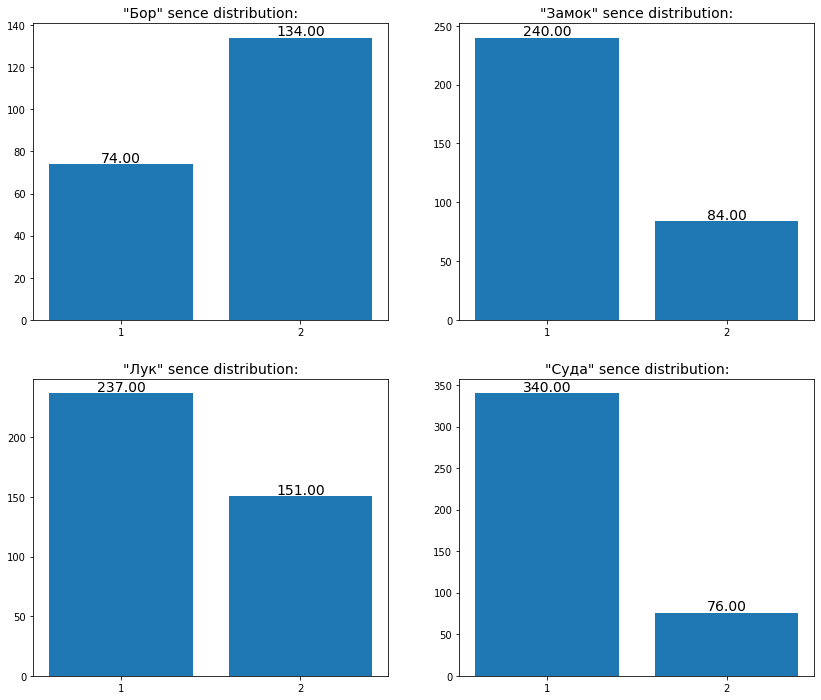

In [14]:
if path_to_train_df == 'train.csv':
    help_dict = {
        1: (0, 0),
        2: (0, 1),
        3: (1, 0),
        4: (1, 1)
    }

    fig, axs = plt.subplots(2, 2)
    counter = 1

    for w, temp_df in train_df.groupby('word'):

        distrib = {'1': 0, '2': 0}

        for i, temp2_df in temp_df.groupby('gold_sense_id'):
            for positions in temp2_df['positions']:
                distrib[str(i)] += len(positions.split(','))
        
        axs[help_dict[counter]].bar(x=list(distrib.keys()), height=list(distrib.values()))
        
        for bar in axs[help_dict[counter]].patches:
            axs[help_dict[counter]].annotate(
                format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=14, xytext=(0, 6),
                textcoords='offset points'
            )

        axs[help_dict[counter]].set_title(f'"{w.capitalize()}" sence distribution:', fontsize=14)

        counter += 1

    fig.set_size_inches(14, 12)
    fig
    fig.show()

else:
    print('None')

### Replacing NaN with 'None' (only for active-dict)

In [15]:
print(f'Count samples without positions: {train_df.positions.isnull().sum()}')

Count samples without positions: 0


In [16]:
train_df.positions.fillna('None', inplace=True) 

In [17]:
print(f'Count samples without positions: {train_df.positions.isnull().sum()}')

Count samples without positions: 0


## Test

In [18]:
test_df = pd.read_csv(path_to_test_df, delimiter='\t', index_col=0)
test_df.head()

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
440,банка,NaN,NaN,"7-12, 36-41",здание банка китая ( макао ) здание банка кита...
441,банка,NaN,NaN,"13-18, 201-206",трехлитровая банка во времена ссср такие банки...
442,банка,NaN,NaN,"21-26, 58-63, 101-106, 263-268, 538-543",здание национального банка украины в здании на...
443,банка,NaN,NaN,"134-139, 262-267, 345-350",зюдфиртель города эссен ( федеральная земля се...
444,банка,NaN,NaN,"43-48, 300-305, 381-386, 521-526",ведения боевых действий полевые учреждения бан...


In [19]:
test_df.shape

(638, 5)

###### Deleting a 'гранат' from dataset (only for wiki-wiki)

In [20]:
if path_to_test_df == 'test.csv':
    test_df = test_df[test_df.word != "гранат"]
    print(test_df.shape)
else:
    print("None")

(618, 5)


### Number of unique words

In [21]:
test_df.word.nunique()

6

In [22]:
test_df.word.value_counts()

граф     148
белка    135
банка    112
бит       84
душ       79
горе      60
Name: word, dtype: int64

### Replacing NaN with 'None' (only  for active-dict)

In [23]:
print(f'Count samples without positions: {test_df.positions.isnull().sum()}')

Count samples without positions: 0


In [24]:
test_df.positions.fillna('None', inplace=True) 

In [25]:
# test_df.iloc[2255:2260]

## 3.3 Getting contextual embeddings with BERT

In [26]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

#### Example

In [27]:
text = "Привет, расскажи, что такое встраиваемые конструкции?"

marked_text = "[CLS] " + text + " [SEP]" # Add special tokens
tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # Convert tokens to their IDs from vocab

print('Input sentece:', text,'\n')
print('After tokenized and added spec tokens:', tokenized_text, '\n')
print('After converted str tokens to IDs:', indexed_tokens)

Input sentece: Привет, расскажи, что такое встраиваемые конструкции? 

After tokenized and added spec tokens: ['[CLS]', 'Привет', ',', 'расскаж', '##и', ',', 'что', 'такое', 'встра', '##иваемые', 'конструкции', '?', '[SEP]'] 

After converted str tokens to IDs: [101, 77527, 128, 61557, 852, 128, 1997, 16570, 64261, 63110, 19253, 166, 102]


#### Loading the pretrained model (weights)

In [28]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    output_hidden_states = True # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Search of the index of "our" target token in the context according to the position coulm

In [29]:
def pos_to_token_id(text: str, pos: Tuple[int, int]) -> int:
    text_before = "[CLS] " + text[:pos[0]]
    tokenized_text = tokenizer.tokenize(text_before) # tokens till target token

    return len(tokenizer.convert_tokens_to_ids(tokenized_text))

#### Search the embeddings for context of the certain word

In [30]:
def get_embedding(df): # df is dataframe for each word

    embeddings = []
    gold_sense_ids = []

    # run through each context for the specified word
    for _, row in df.iterrows(): 
        gold_sense_id = row['gold_sense_id'] # label (only for train)
        text = row['context'] # one context
        
        positions = row['positions'].split(delimeter_for_positions)
        positions = [tuple(map(int, pos.split('-'))) for pos in positions]
        target_token_ids = [pos_to_token_id(text, pos) for pos in positions] # positions of 'our' target tokens in the context

        marked_text = "[CLS] " + text + " [SEP]"

        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)

        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0) # Concatenate the tensors for all layers
        token_embeddings = torch.squeeze(token_embeddings, dim=1) # Remove dimension 1, the "batches"
        token_embeddings = token_embeddings.permute(1,0,2) # Swap dimensions 0 and 1

        # Implement a weighted sum of all tokens in the context
        p_for_target = 0.6 #0.9
        p_for_other = 0.4 #0.1
        
        weight_for_target = p_for_target / len(target_token_ids)
        weight_for_other = p_for_other / (len(token_embeddings) - len(target_token_ids) -2)

        weighted_token_embeds = []

        for token_id in range(1, len(token_embeddings) - 1):
            
            sum_vec = torch.sum(token_embeddings[token_id][-4:], dim=0) # Sum of the vectors from the last four layers.
            
            if token_id in target_token_ids:
                weighted_token_embeds.append(sum_vec.numpy() * weight_for_target)
            else:
                weighted_token_embeds.append(sum_vec.numpy() * weight_for_other)

        embeddings.append(sum(weighted_token_embeds)) # Final embedding of one context. Size: 768.
        gold_sense_ids.append(gold_sense_id)

    return embeddings, gold_sense_ids

## 3.4 Calculation of predict_sense_id

### Search for positions of non-lemmatized words in the context

In [31]:
def find_positions(source_text: str, target_word: str): # This function to restore the position of some words. (active-dict)

    target = mystem.lemmatize(target_word)[0]
    words = re.findall('[А-Яа-яЁё]+', source_text)

    similar_with_target = []
    for word in words:
        if target == mystem.lemmatize(word.lower())[0]:
            similar_with_target.append(word)
    
    similar_with_target = list(set(similar_with_target))
    
    if similar_with_target:
        res_positions = []

        for sim_target in similar_with_target:

            count_target_word = source_text.count(sim_target)
            len_target = len(sim_target)

            end = 0
            for _ in range(count_target_word):
                start = end + source_text[end:].index(sim_target)
                res_positions.append(f'{start}-{start + len_target}')
                end = start + len_target

        return ', '.join(res_positions)
    else:
        return 'None'

### Train

In [32]:
train_df[train_df['positions'] == 'None'].shape[0]

0

In [33]:
train_df['positions'] = train_df.apply(lambda x: find_positions(x.context, x.word) if x.positions == 'None' else x.positions, axis=1)

In [34]:
train_df[train_df['positions'] == 'None'].shape[0]

0

In [35]:
words_train = train_df['word'].unique().tolist()
len(words_train)

4

In [36]:
all_predicts_train = []
ARI = []
for word in words_train:

    temp_df = train_df[train_df['word'] == word] # Create the df for the certain word
    
    embeddings, gold_sense_ids = get_embedding(temp_df[temp_df['positions'] != 'None'])

    count_samples = len(embeddings) # Number of contexts
    print('Length of embedding: ', count_samples)

    # Search the number of clusters for each word
    dict_silh = {}
    for k in range(2, min(count_samples, 6)):
        model_ = KMeans(n_clusters=k, random_state=19)
        model_.fit(embeddings)
        pred = model_.predict(embeddings)
        dict_silh[k] = silhouette_score(embeddings, pred)

    n_calc = max(dict_silh, key=dict_silh.get)
    print("Number of predicted clusters: ", n_calc)

    # Clustering with the selected number of clusters
    kmeans = KMeans(n_clusters=n_calc, random_state=19).fit(embeddings)
    predicts = kmeans.labels_

    pred_labels = iter(predicts.tolist())
    label_for_none = max(predicts) + 1 # Let's combine the contexts with df.position == 'None' into one cluster
    res_labels = []
    for _, row in temp_df.iterrows():
        if row['positions'] != 'None':
            res_labels.append(next(pred_labels))
        else:
            res_labels.append(label_for_none)

    
    all_predicts_train.extend(res_labels)
    ARI.append(adjusted_rand_score(gold_sense_ids, predicts))
    
    print("Current word: ", word)
    print("Silhouette Score: ", dict_silh[n_calc])
    print("Adjusted Rand Score: ", adjusted_rand_score(gold_sense_ids, predicts))
    print()

print(statistics.mean(ARI))

Length of embedding:  138
Number of predicted clusters:  2
Current word:  замок
Silhouette Score:  0.1204688
Adjusted Rand Score:  0.8826724735997273

Length of embedding:  110
Number of predicted clusters:  2
Current word:  лук
Silhouette Score:  0.19694819
Adjusted Rand Score:  0.7271202910466993

Length of embedding:  135
Number of predicted clusters:  2
Current word:  суда
Silhouette Score:  0.2480749
Adjusted Rand Score:  1.0

Length of embedding:  56
Number of predicted clusters:  2
Current word:  бор
Silhouette Score:  0.2605024
Adjusted Rand Score:  1.0

0.9024481911616067


In [37]:
print(statistics.mean(ARI))

0.9024481911616067


In [38]:
len(all_predicts_train)

439

In [39]:
train_df.head(3)

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...


In [40]:
train_df['predict_sense_id'] = all_predicts_train

In [41]:
train_df.head(3)

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
1,замок,1,0,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
2,замок,1,0,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
3,замок,1,0,299-304,проведения архитектурно - археологических рабо...


In [42]:
mask = train_df.positions == 'None'
train_df[mask]

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,


In [43]:
train_df[mask].predict_sense_id.value_counts()

Series([], Name: predict_sense_id, dtype: int64)

## Test

In [44]:
test_df[test_df['positions'] == 'None'].shape[0]

0

In [45]:
test_df['positions'] = test_df.apply(lambda x: find_positions(x.context, x.word) if x.positions == 'None' else x.positions, axis=1)

In [46]:
test_df[test_df['positions'] == 'None'].shape[0]

0

In [47]:
words_test = test_df['word'].unique().tolist()
len(words_test)

6

In [48]:
all_predicts_test = []

for word in words_test:

    temp_df = test_df[test_df['word'] == word]

    embeddings, _ = get_embedding(temp_df[temp_df['positions'] != 'None'])

    count_samples = len(embeddings)
    print('Length of embedding: ', count_samples)

    dict_silh = {}
    for k in range(2, min(count_samples, 6)):
        model_ = KMeans(n_clusters=k, random_state=19)
        model_.fit(embeddings)
        pred = model_.predict(embeddings)
        dict_silh[k] = silhouette_score(embeddings, pred)

    n_calc = max(dict_silh, key=dict_silh.get)
    

    print("Number of predicted clusters: ", n_calc)

    kmeans = KMeans(n_clusters=n_calc, random_state=19).fit(embeddings)
    predicts = kmeans.labels_

    pred_labels = iter(predicts.tolist())
    label_for_none = max(predicts) + 1
    res_labels = []
    for _, row in temp_df.iterrows():
        if row['positions'] != 'None':
            res_labels.append(next(pred_labels))
        else:
            res_labels.append(label_for_none)
    
    all_predicts_test.extend(res_labels)

    print("Current word: ", word)
    print()

Length of embedding:  112
Number of predicted clusters:  2
Current word:  банка

Length of embedding:  135
Number of predicted clusters:  4
Current word:  белка

Length of embedding:  84
Number of predicted clusters:  2
Current word:  бит

Length of embedding:  60
Number of predicted clusters:  2
Current word:  горе

Length of embedding:  148
Number of predicted clusters:  2
Current word:  граф

Length of embedding:  79
Number of predicted clusters:  3
Current word:  душ



In [49]:
len(all_predicts_test)

618

In [50]:
test_df.head()

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
440,банка,NaN,NaN,"7-12, 36-41",здание банка китая ( макао ) здание банка кита...
441,банка,NaN,NaN,"13-18, 201-206",трехлитровая банка во времена ссср такие банки...
442,банка,NaN,NaN,"21-26, 58-63, 101-106, 263-268, 538-543",здание национального банка украины в здании на...
443,банка,NaN,NaN,"134-139, 262-267, 345-350",зюдфиртель города эссен ( федеральная земля се...
444,банка,NaN,NaN,"43-48, 300-305, 381-386, 521-526",ведения боевых действий полевые учреждения бан...


In [51]:
test_df['predict_sense_id'] = all_predicts_test

In [52]:
test_df.head()

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,
440,банка,NaN,1,"7-12, 36-41",здание банка китая ( макао ) здание банка кита...
441,банка,NaN,0,"13-18, 201-206",трехлитровая банка во времена ссср такие банки...
442,банка,NaN,1,"21-26, 58-63, 101-106, 263-268, 538-543",здание национального банка украины в здании на...
443,банка,NaN,1,"134-139, 262-267, 345-350",зюдфиртель города эссен ( федеральная земля се...
444,банка,NaN,1,"43-48, 300-305, 381-386, 521-526",ведения боевых действий полевые учреждения бан...


In [53]:
mask = test_df.positions == 'None'
test_df[mask]

,word,gold_sense_id,predict_sense_id,positions,context
context_id,,,,,


In [54]:
test_df[mask].predict_sense_id.value_counts()

Series([], Name: predict_sense_id, dtype: int64)

In [55]:
test_df.predict_sense_id.value_counts()

1    371
0    176
2     62
3      9
Name: predict_sense_id, dtype: int64

In [56]:
test_df = test_df.drop(['gold_sense_id', 'positions'], axis=1)
test_df = test_df.reset_index(level=0)
test_df.head()

,context_id,word,predict_sense_id,context
0,440,банка,1,здание банка китая ( макао ) здание банка кита...
1,441,банка,0,трехлитровая банка во времена ссср такие банки...
2,442,банка,1,здание национального банка украины в здании на...
3,443,банка,1,зюдфиртель города эссен ( федеральная земля се...
4,444,банка,1,ведения боевых действий полевые учреждения бан...


In [57]:
test_df.to_csv(path_to_output, sep = '\t', index = False)